<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex05/Pedro%20Gengo/Pedro_Gengo_Aula_5_Exerc%C3%ADcio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
nome = 'Pedro Gabriel Gengo Lourenço'

print(f'Meu nome é {nome}')

Meu nome é Pedro Gabriel Gengo Lourenço


Este exercicío consiste em treinar no MNIST um modelo de duas camadas, sendo a primeira uma camada convolucional e a segunda uma camada linear de classificação.

Não podemos usar as funções torch.nn.Conv{1,2,3}d

## Importação das bibliotecas

In [126]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [127]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Define pesos iniciais

In [128]:
in_channels = 1
out_channels = 2
kernel_size = 5
stride = 3

# Input image size
height_in = 28  
width_in = 28

# Image size after the first convolutional layer.
height_out = (height_in - kernel_size) // stride + 1
width_out = (width_in - kernel_size) // stride + 1

initial_conv_weight = torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01)
initial_conv_bias = torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01)

initial_classification_weight = torch.FloatTensor(10, out_channels * height_out * width_out).uniform_(-0.01, 0.01)
initial_classification_bias = torch.FloatTensor(10,).uniform_(-0.01, 0.01)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [129]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [130]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [131]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

## Define os pesos iniciais

In [132]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [133]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Camada Convolucional

In [200]:
class MyConv2d(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size  # The same for height and width.
        self.stride = stride  # The same for height and width.
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01))
        self.bias = torch.nn.Parameter(torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01))

    def forward(self, x):
        assert x.dim() == 4, f'x must have 4 dimensions: {x.shape}'

        # Definindo os limites da imagem, ou seja, o pixel em que comeco e o pixel em que termino, para altura e largura
        # Exemplo: uma imagem 28x28, com um kernel de 3x3, irá gerar uma imagem de 26x26 como saída, pois perdemos alguns pixels na borda
        start_width = 0 + self.kernel_size // 2
        end_width = x.shape[2] - (self.kernel_size - start_width - 1)
        start_height = 0 + self.kernel_size // 2
        end_height = x.shape[3] - (self.kernel_size - start_height - 1)

        # Essa será a imagem de saída. Irei popular ela a medida que calcular os valores de cada pixel
        # Em seu tamanho, levo em conta o stride
        valid_image = torch.zeros((x.shape[0], self.out_channels, (end_width - start_width) // self.stride, (end_height - start_height) // self.stride))

        # Loop nos filtros
        for idx_filter, filter_bias in enumerate(zip(self.weight, self.bias)): # Andando com passo do stride
          filter, bias = filter_bias
          idx_valid_image_i = 0 # Contador criado para usar na imagem que irei retornar, para preservar os indices corretos
          for i in range(start_width, end_width, self.stride):
            idx_valid_image_j = 0 # Contador criado para usar na imagem que irei retornar, para preservar os indices corretos
            for j in range(start_height, end_height, self.stride): # Andando com passo do stride

              # Encontro a janela da imagem original referente ao pixel x da imagem de saida. Essa janela tem tamanho do kernel
              window = x[
                         :,
                         :,
                         i - self.kernel_size // 2: i + (self.kernel_size - (self.kernel_size // 2) - 1) + 1,
                         j - self.kernel_size // 2: j + (self.kernel_size - (self.kernel_size // 2) - 1) + 1
                        ]

              # Faço o cálculo do novo pixel, sendo: janela * filtro + bias
              valid_image[:, idx_filter, idx_valid_image_i, idx_valid_image_j] = torch.sum(window * filter, dim=(1, 2, 3)) + bias
              idx_valid_image_j += 1
            idx_valid_image_i += 1
        out = valid_image
        return out

In [201]:
x.shape

torch.Size([1, 1, 5, 6])

In [202]:
torch.sum(x, (1, 2, 3)).shape

torch.Size([1])

## Compare se sua implementação está igual à do pytorch usando um exemplo simples

In [203]:
in_channels_dummy = 1
out_channels_dummy = 1
kernel_size_dummy = 2
stride_dummy = 1

conv_layer = MyConv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(in_channels_dummy, out_channels_dummy, kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()

conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy
pytorch_conv_layer.load_state_dict(dict(weight=initial_weights_dummy, bias=initial_bias_dummy))

x = torch.arange(30).float().reshape(1, 1, 5, 6)

out = conv_layer(x)
print(out)
target_out = pytorch_conv_layer(x)
print(target_out)

assert torch.allclose(out, target_out, atol=1e-6)

tensor([[[[ 34.,  40.,  46.,  52.,  58.],
          [ 70.,  76.,  82.,  88.,  94.],
          [106., 112., 118., 124., 130.],
          [142., 148., 154., 160., 166.]]]], grad_fn=<CopySlices>)
tensor([[[[ 34.,  40.,  46.,  52.,  58.],
          [ 70.,  76.,  82.,  88.,  94.],
          [106., 112., 118., 124., 130.],
          [142., 148., 154., 160., 166.]]]], grad_fn=<ConvolutionBackward0>)


## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [204]:
x = torch.rand(2, in_channels, height_in, width_in)

conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
conv_layer.weight.data = initial_conv_weight
conv_layer.bias.data = initial_conv_bias
pytorch_conv_layer.load_state_dict(dict(weight=initial_conv_weight, bias=initial_conv_bias))

out = conv_layer(x)
print(out.shape)
target_out = pytorch_conv_layer(x)
print(target_out.shape)

assert torch.allclose(out, target_out, atol=1e-6)

torch.Size([2, 2, 8, 8])
torch.Size([2, 2, 8, 8])


## Modelo

In [205]:
class Net(torch.nn.Module):
    def __init__(self, height_in: int, width_in: int, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(Net, self).__init__()
        self.conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
   
        height_out = (height_in - kernel_size - 1) // stride + 1
        width_out = (width_in - kernel_size - 1) // stride + 1
        self.classification_layer = torch.nn.Linear(out_channels * height_out * width_out, 10)

    def forward(self, x):
        hidden = self.conv_layer(x)
        hidden = torch.nn.functional.relu(hidden)
        hidden = hidden.reshape(x.shape[0], -1)
        logits = self.classification_layer(hidden)
        return logits

## Treinamento

### Definição dos hiperparâmetros

In [206]:
n_epochs = 50
lr = 0.1

### Laço de treinamento

In [207]:
model = Net(height_in=height_in, width_in=width_in, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

# Usa pesos iniciais pré-difinidos
model.classification_layer.load_state_dict(dict(weight=initial_classification_weight, bias=initial_classification_bias))
model.conv_layer.weight.data = initial_conv_weight
model.conv_layer.bias.data = initial_conv_bias

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    for x_train, y_train in loader_train:
        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 2.303267478942871
Epoch: 1/49 Loss: 2.227701187133789
Epoch: 2/49 Loss: 1.0923893451690674
Epoch: 3/49 Loss: 0.5867355465888977
Epoch: 4/49 Loss: 0.5144088864326477
Epoch: 5/49 Loss: 0.4502663016319275
Epoch: 6/49 Loss: 0.4075140357017517
Epoch: 7/49 Loss: 0.37713873386383057
Epoch: 8/49 Loss: 0.35344862937927246
Epoch: 9/49 Loss: 0.3341451585292816
Epoch: 10/49 Loss: 0.3181139826774597
Epoch: 11/49 Loss: 0.30457887053489685
Epoch: 12/49 Loss: 0.292834997177124
Epoch: 13/49 Loss: 0.28276076912879944
Epoch: 14/49 Loss: 0.27383318543434143
Epoch: 15/49 Loss: 0.2657742202281952
Epoch: 16/49 Loss: 0.2583288252353668
Epoch: 17/49 Loss: 0.2511751055717468
Epoch: 18/49 Loss: 0.24439717829227448
Epoch: 19/49 Loss: 0.23789966106414795
Epoch: 20/49 Loss: 0.2316770702600479
Epoch: 21/49 Loss: 0.22562645375728607
Epoch: 22/49 Loss: 0.21984529495239258
Epoch: 23/49 Loss: 0.2142912745475769
Epoch: 24/49 Loss: 0.2089422196149826
Epoch: 25/49 Loss: 0.203872948884964
Epoch: 26/49 Loss

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

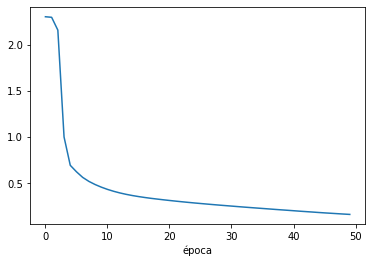

In [208]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [209]:
loss_epoch_end

[2.303267478942871,
 2.227701187133789,
 1.0923893451690674,
 0.5867355465888977,
 0.5144088864326477,
 0.4502663016319275,
 0.4075140357017517,
 0.37713873386383057,
 0.35344862937927246,
 0.3341451585292816,
 0.3181139826774597,
 0.30457887053489685,
 0.292834997177124,
 0.28276076912879944,
 0.27383318543434143,
 0.2657742202281952,
 0.2583288252353668,
 0.2511751055717468,
 0.24439717829227448,
 0.23789966106414795,
 0.2316770702600479,
 0.22562645375728607,
 0.21984529495239258,
 0.2142912745475769,
 0.2089422196149826,
 0.203872948884964,
 0.19903425872325897,
 0.1943996250629425,
 0.18994112312793732,
 0.1856399029493332,
 0.18147501349449158,
 0.17744922637939453,
 0.17347262799739838,
 0.1694747358560562,
 0.16547317802906036,
 0.16150495409965515,
 0.15746407210826874,
 0.1534043401479721,
 0.14926917850971222,
 0.14520631730556488,
 0.14123666286468506,
 0.1371268630027771,
 0.1331036537885666,
 0.12914671003818512,
 0.125150665640831,
 0.12116766721010208,
 0.11731737107038

In [210]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    2.303267478942871,
    2.227701187133789,
    1.0923893451690674,
    0.5867354869842529,
    0.5144089460372925,
    0.45026642084121704,
    0.4075140357017517,
    0.37713879346847534,
    0.3534485101699829,
    0.3341451585292816,
    0.3181140422821045,
    0.30457887053489685,
    0.29283496737480164,
    0.2827608287334442,
    0.2738332152366638,
    0.2657742500305176,
    0.2583288848400116,
    0.25117507576942444,
    0.24439716339111328,
    0.23789969086647034,
    0.23167723417282104,
    0.22562651336193085,
    0.21984536945819855,
    0.2142913043498993,
    0.20894232392311096,
    0.203872948884964,
    0.19903430342674255,
    0.19439971446990967,
    0.18994088470935822,
    0.18563991785049438,
    0.18147490918636322,
    0.17744913697242737,
    0.17347246408462524,
    0.16947467625141144,
    0.16547319293022156,
    0.16150487959384918,
    0.1574639081954956,
    0.1534043848514557,
    0.14926929771900177,
    0.1452063024044037,
    0.1412365883588791,
    0.13712672889232635,
    0.1331038922071457,
    0.1291467249393463,
    0.1251506358385086,
    0.12116757035255432,
    0.11731722950935364,
    0.11364627629518509,
    0.11001908034086227,
    0.10655981302261353])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)